Import necessary packages

In [1]:
import os
from PIL import Image

cv2-OpenCV->Computer Vision Library \
tqdm- display progress bars for loops and operations

In [2]:
import cv2
import numpy as np
from tqdm import tqdm
import random

Path to the MRI image directory

In [3]:
mri_dir = r'C:\Users\Dell\Desktop\MAJOR PROJECT RESOURCES\Major Project Final Datasets\MRI'

Listing all files in the directory

In [4]:
files = os.listdir(mri_dir)
print(f"Found {len(files)} files.")

Found 2300 files.


Preview first few filenames

In [5]:
print("Sample files:", files[:5])

Sample files: ['alzheimer_1.png', 'alzheimer_100.png', 'alzheimer_1008.png', 'alzheimer_1011.png', 'alzheimer_1015.png']


Display image size and format for the images

In [6]:
for file in files[:3]:
    file_path = os.path.join(mri_dir, file)
    try:
        with Image.open(file_path) as img:
            print(f"{file}: format={img.format}, size={img.size}, mode={img.mode}")
            # img.show()  # Opens image viewer (optional)
    except Exception as e:
        print(f"Error opening {file}: {e}")

alzheimer_1.png: format=PNG, size=(128, 128), mode=L
alzheimer_100.png: format=PNG, size=(128, 128), mode=L
alzheimer_1008.png: format=PNG, size=(128, 128), mode=L


Data Augmentation

In [7]:
def random_rotate(img):
    angle = random.choice([0, 90, 180, 270])
    if angle == 0:
        return img
    return cv2.rotate(img, {90:cv2.ROTATE_90_CLOCKWISE, 180:cv2.ROTATE_180, 270:cv2.ROTATE_90_COUNTERCLOCKWISE}[angle])

In [8]:
def random_flip(img):
    if random.random() > 0.5:
        img = cv2.flip(img, 1)  # horizontal flip
    if random.random() > 0.5:
        img = cv2.flip(img, 0)  # vertical flip
    return img

In [9]:
def add_noise(img):
    noise = np.random.normal(0, 0.02, img.shape)
    img_noisy = img + noise
    img_noisy = np.clip(img_noisy, 0., 1.)
    return img_noisy

Main preprocessing and augmentation function

In [10]:
def preprocess_and_augment_images(
        image_dir, 
        save_dir, 
        augment=False, 
        augment_count=2, 
        target_size=(128, 128)):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    cleaned_filenames = []

    for file in tqdm(os.listdir(image_dir)):
        file_path = os.path.join(image_dir, file)

        try:
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Skipping unreadable file {file}")
                continue
        except Exception as e:
            print(f"Error reading file {file}: {e}")
            continue

        if img.shape != target_size:
            img = cv2.resize(img, target_size)
        
        img_norm = img.astype(np.float32) / 255.0

        norm_save_path = os.path.join(save_dir, file.replace('.png', '.npy'))
        np.save(norm_save_path, img_norm)
        cleaned_filenames.append(file)
        
        # ---------- Augmentation ----------
        if augment:
            for i in range(augment_count):
                aug_img = img_norm.copy()     # Start from normalized clean image
                aug_img = random_rotate(aug_img)
                aug_img = random_flip(aug_img)
                aug_img = add_noise(aug_img)

                aug_save_path = os.path.join(
                    save_dir, f"{file.replace('.png', '')}_aug{i+1}.npy")
                np.save(aug_save_path, aug_img)
    
    print(f"Finished. Preprocessed {len(cleaned_filenames)} images.")

In [11]:
image_dir = r'C:\Users\Dell\Desktop\MAJOR PROJECT RESOURCES\Major Project Final Datasets\MRI'        # Replace with actual path
save_dir = r'C:\Users\Dell\Desktop\M PROJECT\Preprocessed dataset'          # Destination for processed files

In [15]:
preprocess_and_augment_images(
    image_dir, 
    save_dir, 
    augment=True,        # Enable or disable augmentation
    augment_count=3,     # Number of augmentations per image
    target_size=(128,128) # Your images' current size
)

100%|██████████| 2300/2300 [00:26<00:00, 87.28it/s] 

Finished. Preprocessed 2300 images.


Pixel Value Distribution:

In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [23]:
# def plot_pixel_distribution(image_dir):
#     pixel_values = []
    
#     for file in os.listdir(image_dir):
#         file_path = os.path.join(image_dir, file)
#         if file.endswith('.npy'):
#             img = np.load(file_path)
#             pixel_values.extend(img.flatten())
    
#     plt.hist(pixel_values, bins=50, range=(0, 1), color='blue', alpha=0.7)
#     plt.title("Pixel Value Distribution")
#     plt.xlabel("Pixel Value")
#     plt.ylabel("Frequency")
#     plt.show()

# # Call this after preprocessing to visualize pixel distributions
# plot_pixel_distribution(save_dir)

Visualize Preprocessed Images (including Augmented Images)

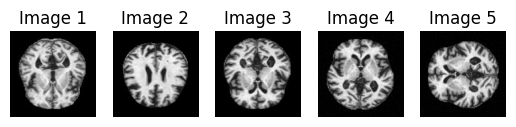

In [13]:
def visualize_preprocessed_images(save_dir, num_images=5):
    # List all preprocessed .npy files
    files = [f for f in os.listdir(save_dir) if f.endswith('.npy')]
    
    for i, file in enumerate(files[:num_images]):
        img = np.load(os.path.join(save_dir, file))
        
        # Convert the float32 image to uint8 (scale back to 0-255)
        img = (img * 255).astype(np.uint8)
        
        # Convert to 3 channels for visualization (if grayscale)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis('off')
    
    plt.show()

# Visualize some preprocessed images
visualize_preprocessed_images(save_dir, num_images=5)


Compare Original and Preprocessed Images

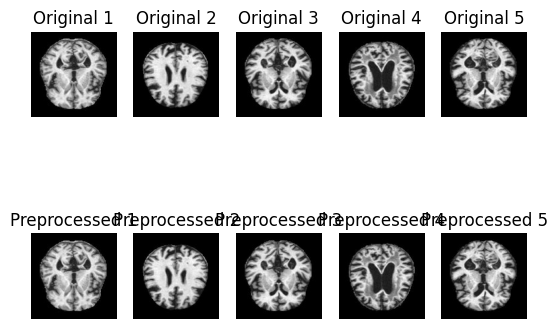

In [14]:
def compare_images(original_dir, preprocessed_dir, num_images=5):
    original_files = [f for f in os.listdir(original_dir) if f.endswith('.png')]
    preprocessed_files = [f for f in os.listdir(preprocessed_dir) if f.endswith('.npy')]

    for i, file in enumerate(original_files[:num_images]):
        original_path = os.path.join(original_dir, file)
        preprocessed_path = os.path.join(preprocessed_dir, file.replace('.png', '.npy'))

        original_img = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)
        preprocessed_img = np.load(preprocessed_path)

        plt.subplot(2, num_images, i+1)
        plt.imshow(original_img, cmap='gray')
        plt.title(f"Original {i+1}")
        plt.axis('off')

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(preprocessed_img, cmap='gray')
        plt.title(f"Preprocessed {i+1}")
        plt.axis('off')

    plt.show()

# Compare the original and preprocessed images
compare_images(image_dir, save_dir)

Check Image Shape and Size

In [15]:
def check_image_sizes(save_dir, target_size=(128, 128)):
    mismatch_count = 0
    for file in os.listdir(save_dir):
        if file.endswith('.npy'):
            img = np.load(os.path.join(save_dir, file))
            if img.shape != target_size:
                print(f"Image {file} does not match target size {target_size}.")
                mismatch_count += 1
    
    if mismatch_count == 0:
        print(f"All images are of the correct size: {target_size}")
    else:
        print(f"Found {mismatch_count} images with incorrect size.")

# Check for any size mismatches
check_image_sizes(save_dir, target_size=(128, 128))

All images are of the correct size: (128, 128)


Basic Statistical Analysis

In [16]:
def calculate_image_statistics(save_dir):
    means = []
    std_devs = []
    
    for file in os.listdir(save_dir):
        if file.endswith('.npy'):
            img = np.load(os.path.join(save_dir, file))
            means.append(np.mean(img))
            std_devs.append(np.std(img))
    
    print(f"Mean pixel value: {np.mean(means):.4f}")
    print(f"Standard deviation: {np.mean(std_devs):.4f}")

# Calculate mean and standard deviation of the preprocessed images
calculate_image_statistics(save_dir)

Mean pixel value: 0.2193
Standard deviation: 0.2387


In [17]:
import os

def count_preprocessed_images(save_dir):
    # List all .npy files in the save directory
    files = [f for f in os.listdir(save_dir) if f.endswith('.npy')]
    
    # Return the count of .npy files
    return len(files)

# Count the number of preprocessed images
num_images = count_preprocessed_images(save_dir)
print(f"Number of preprocessed images: {num_images}")

Number of preprocessed images: 9200


Task - Count no of images of each diseases!!

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# def plot_sample_images(image_dir, title, sample_count=5):
#     files = os.listdir(image_dir)[:sample_count]
#     plt.figure(figsize=(15, 3))
#     for i, file in enumerate(files):
#         img = Image.open(os.path.join(image_dir, file))
#         plt.subplot(1, sample_count, i + 1)
#         plt.imshow(img, cmap='gray')
#         plt.title(f'{title}\n{file}')
#         plt.axis('off')
#     plt.show()

# def plot_sample_npy_images(npy_dir, title, sample_count=5):
#     files = [f for f in os.listdir(npy_dir) if f.endswith('.npy')][:sample_count]
#     plt.figure(figsize=(15, 3))
#     for i, file in enumerate(files):
#         img_array = np.load(os.path.join(npy_dir, file))
#         plt.subplot(1, sample_count, i + 1)
#         plt.imshow(img_array, cmap='gray')
#         plt.title(f'{title}\n{file}')
#         plt.axis('off')
#     plt.show()



In [32]:
# def plot_intensity_histograms(image_dir, title, sample_count=50):
#     intensities = []
#     files = os.listdir(image_dir)[:sample_count]
#     for file in files:
#         img = Image.open(os.path.join(image_dir, file))
#         intensities.extend(np.array(img).flatten())
#     plt.hist(intensities, bins=50, alpha=0.7)
#     plt.title(f'Intensity Histogram: {title}')
#     plt.xlabel('Pixel Intensity')
#     plt.ylabel('Frequency')
#     plt.show()

In [21]:
def plot_statistics_comparison(raw_dir, preprocessed_dir):
    raw_means, preproc_means = [], []
    raw_stds, preproc_stds = [], []

    raw_files = os.listdir(raw_dir)[:100]
    preproc_files = os.listdir(preprocessed_dir)[:100]

    for file in raw_files:
        img = Image.open(os.path.join(raw_dir, file))
        arr = np.array(img)
        raw_means.append(arr.mean())
        raw_stds.append(arr.std())

    for file in preproc_files:
        # Assuming preprocessed images saved as .npy arrays
        arr = np.load(os.path.join(preprocessed_dir, file))
        preproc_means.append(arr.mean())
        preproc_stds.append(arr.std())

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.boxplot([raw_means, preproc_means], labels=['Raw', 'Preprocessed'])
    plt.title('Mean Intensity Comparison')

    plt.subplot(1, 2, 2)
    plt.boxplot([raw_stds, preproc_stds], labels=['Raw', 'Preprocessed'])
    plt.title('Standard Deviation Comparison')

    plt.show()

In [ ]:
raw_image_dir = r'C:\Users\Dell\Desktop\MAJOR PROJECT RESOURCES\Major Project Final Datasets\MRI'
preprocessed_dir = r'C:\Users\Dell\Desktop\M PROJECT\Preprocessed dataset'


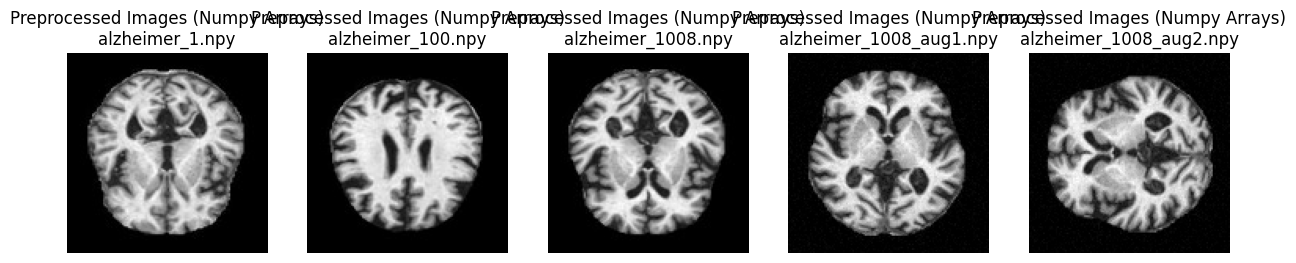

In [28]:
def plot_sample_npy_images(npy_dir, title, sample_count=5):
    files = [f for f in os.listdir(npy_dir) if f.endswith('.npy')][:sample_count]
    plt.figure(figsize=(15, 3))
    for i, file in enumerate(files):
        img_array = np.load(os.path.join(npy_dir, file))
        plt.subplot(1, sample_count, i + 1)
        plt.imshow(img_array, cmap='gray')
        plt.title(f'{title}\n{file}')
        plt.axis('off')
    plt.show()

# Usage
plot_sample_npy_images(preprocessed_dir, 'Preprocessed Images (Numpy Arrays)')

In [29]:
# plot_sample_images(raw_image_dir, 'Raw Images')
# plot_sample_images(preprocessed_dir, 'Preprocessed Images (Numpy Arrays)')

In [31]:
# plot_intensity_histograms(raw_image_dir, 'Raw Images')
# plot_intensity_histograms(preprocessed_dir, 'Preprocessed Images')

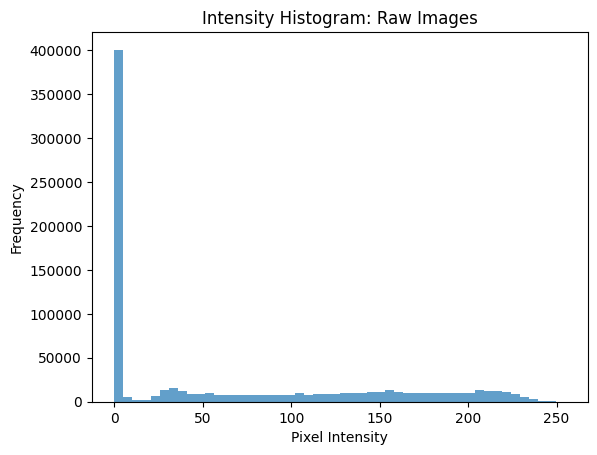

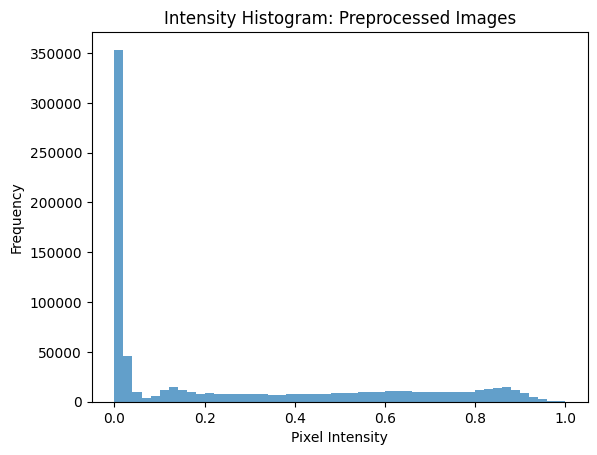

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def plot_intensity_histograms(image_dir, title, sample_count=50):
    intensities = []
    files = os.listdir(image_dir)[:sample_count]
    for file in files:
        file_path = os.path.join(image_dir, file)
        try:
            if file.endswith('.npy'):
                img_array = np.load(file_path)
            else:
                with Image.open(file_path) as img:
                    img_array = np.array(img)
            intensities.extend(img_array.flatten())
        except Exception as e:
            print(f"Skipping file {file} due to error: {e}")
            continue
    plt.hist(intensities, bins=50, alpha=0.7)
    plt.title(f'Intensity Histogram: {title}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

# Usage
plot_intensity_histograms(raw_image_dir, 'Raw Images')
plot_intensity_histograms(preprocessed_dir, 'Preprocessed Images')


C:\Users\Dell\AppData\Local\Temp\ipykernel_16928\3138756291.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([raw_means, preproc_means], labels=['Raw', 'Preprocessed'])
C:\Users\Dell\AppData\Local\Temp\ipykernel_16928\3138756291.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([raw_stds, preproc_stds], labels=['Raw', 'Preprocessed'])


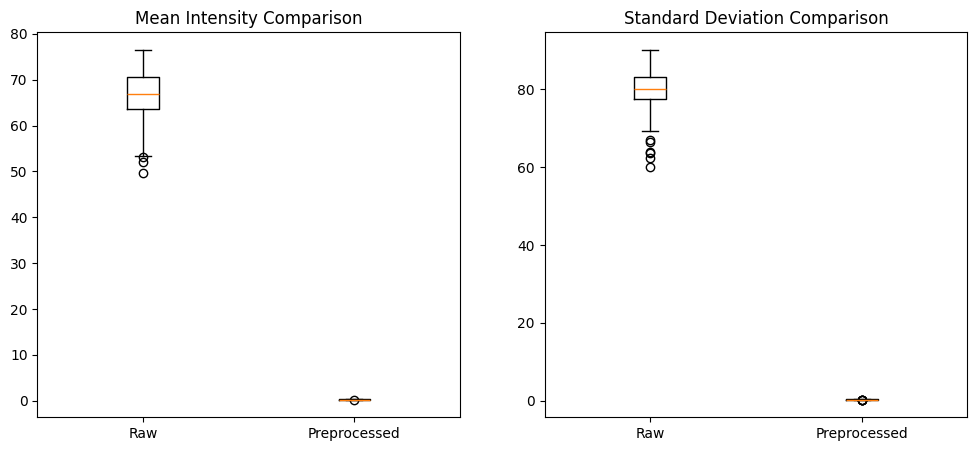

In [25]:
plot_statistics_comparison(raw_image_dir, preprocessed_dir)

In [ ]:
# import numpy as np

# def calculate_snr(image, background_mask):
#     """
#     Calculate Signal-to-Noise Ratio (SNR)
#     image: 2D numpy array of image intensities
#     background_mask: boolean numpy array where True indicates background pixels for noise estimation
#     """
#     signal_mean = np.mean(image[~background_mask])  # signal region (non-background)
#     noise_std = np.std(image[background_mask])      # noise from background region
#     snr = signal_mean / noise_std if noise_std != 0 else 0
#     return snr

# def calculate_cnr(image, region1_mask, region2_mask, background_mask):
#     """
#     Calculate Contrast-to-Noise Ratio (CNR)
#     region1_mask, region2_mask: boolean masks for two regions of interest
#     background_mask: boolean mask for background noise region
#     """
#     mean1 = np.mean(image[region1_mask])
#     mean2 = np.mean(image[region2_mask])
#     noise_std = np.std(image[background_mask])
#     cnr = abs(mean1 - mean2) / noise_std if noise_std != 0 else 0
#     return cnr

# # Example usage:
# # Assuming image is a 2D numpy array,
# # background_mask identifies background pixels (e.g., outside brain),
# # region masks identify tissue areas (e.g., gray matter, white matter)

# # You need to define or generate these masks, possibly using simple intensity thresholding or manual annotation.

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# def visualize_augmentation(original_img, augmented_imgs, titles=None):
#     """
#     original_img: 2D numpy array of original image (normalized floats)
#     augmented_imgs: list of 2D numpy arrays of augmented images
#     titles: list of strings titles for each augmented image
#     """
#     total = 1 + len(augmented_imgs)
#     plt.figure(figsize=(4 * total, 4))
    
#     plt.subplot(1, total, 1)
#     plt.imshow(original_img, cmap='gray')
#     plt.title("Original")
#     plt.axis('off')
    
#     for i, aug_img in enumerate(augmented_imgs):
#         plt.subplot(1, total, i + 2)
#         plt.imshow(aug_img, cmap='gray')
#         title = titles[i] if titles and i < len(titles) else f"Augmented {i+1}"
#         plt.title(title)
#         plt.axis('off')
#     plt.show()

# # Example usage:
# # Assuming an original image and list of augmented images (all numpy arrays normalized between 0 and 1)
# # visualize_augmentation(orig_img, [aug_img1, aug_img2, aug_img3])